# Species diversity in enriched flagellins

In [1]:
library(seqinr)
library(phyloseq)
library(tidyverse)
library(metagMisc)
library(microViz)
library(conflicted)
library(pheatmap)
library(viridis)
library(gridExtra)
library(ggplot2)
library(pheatmap)

── Attaching packages ──────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.4     ✔ purrr   1.0.2
✔ tibble  3.2.1     ✔ dplyr   1.1.4
✔ tidyr   1.3.0     ✔ stringr 1.5.1
✔ readr   2.1.4     ✔ forcats 1.0.0
── Conflicts ─────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::count()  masks seqinr::count()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘metagMisc’


The following object is masked from ‘package:purrr’:

    some



microViz version 0.9.6 - Copyright (C) 2022 David Barnett
* Website: https://david-barnett.github.io/microViz/
* Useful? For citation info, run: citation('microViz')
* Silence: suppressPackageStartupMessages(library(microViz))


Loading required package: viridisLite



### Declare preferences

In [2]:
conflict_prefer("count","dplyr")
conflict_prefer("filter","dplyr")

[conflicted] Will prefer dplyr::count over any other package.
[conflicted] Will prefer dplyr::filter over any other package.


### Source functions

In [3]:
#Import miscellaneous functions for plots and edger
source("/ebio/abt3_projects2/Flagellin_Diversity/code/notebooks/FlagellinDiversity/plots_functions.r")

In [4]:
setwd("/ebio/abt3_projects2/Flagellin_Diversity/code/notebooks/shortbred/edgeR")

### Import files

In [5]:
#Import complete flagellin database
flagellins.markers.sb=seqinr::read.fasta("/ebio/abt3_projects/small_projects/aborbon/Thesis_FlagellinDiversity/1_shortbred/out.finalmap.faa",seqtype="AA")

In [6]:
DA.biome1 = read_tsv("subsampled_opt1/DA.host.env.tsv",col_names=T)
DA.animalsvsplants = read_tsv("subsampled_opt1/DA.animal.plants.tsv",col_names=T)

Rows: 623 Columns: 13
── Column specification ─────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (9): Accession, Domain, Phylum, Class, Order, Family, Genus, Species, En...
dbl (4): logFC, logCPM, PValue, FDR

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 203 Columns: 13
── Column specification ─────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (9): Accession, Domain, Phylum, Class, Order, Family, Genus, Species, En...
dbl (4): logFC, logCPM, PValue, FDR

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
DA.env = filter(DA.biome1,EnrichedIn=="Environmental")
DA.host = filter(DA.biome1,EnrichedIn=="Host-associated")
tmpPl = filter(DA.animalsvsplants,EnrichedIn=="Plants")
tmpAn = filter(DA.animalsvsplants,EnrichedIn=="Animals")

# Compare species diversity of enriched flagellins per biome

In [8]:
listEnrichedBiomes = list(free_living=DA.env,host=DA.host,plants=tmpPl,animals=tmpAn)

In [9]:
taxSummary = lapply(listEnrichedBiomes,getTaxSummary)

In [10]:
taxSummBiomes = bind_rows(taxSummary)
taxSummBiomes

EnrichedIn,totalEnriched,NoPhyla,NoClass,NoOrder,NoFamily,NoGenus,NoSpecies
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
Environmental,513,24,39,84,139,312,442
Host-associated,110,6,7,15,21,49,81
Plants,82,5,7,12,20,39,71
Animals,121,6,7,18,26,54,85


In [11]:
library(reshape2)

In [24]:
meltTaxBiomes.host = melt(taxSummBiomes) %>%
    filter(EnrichedIn%in%c("Plants","Animals"))%>%
    mutate(variable = str_remove_all(variable,"No"))%>%

Using EnrichedIn as id variables



In [13]:
head(meltTaxBiomes)


,EnrichedIn,variable,value
,<chr>,<chr>,<int>
1,Environmental,totalEnriched,513
2,Host-associated,totalEnriched,110
3,Environmental,Phyla,24
4,Host-associated,Phyla,6
5,Environmental,Class,39
6,Host-associated,Class,7


In [14]:
cols.biome = read_tsv("../../FlagellinDiversity/Figures//colors.map.tsv")

Rows: 11 Columns: 2
── Column specification ─────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): biome, color

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [15]:
cols.biome

biome,color
<chr>,<chr>
Environmental,#E64B35FF
Host-associated,#4DBBD5FF
Plants,#00A087FF
Animal,#3C5488FF
Actinopterygii,#F39B7FFF
Reptilia,#8491B4FF
Amphibia,#91D1C2FF
Aves,#DC0000FF
Mammals,#7E6148FF


In [ ]:
meltTaxBiomes$variable <- factor(meltTaxBiomes$variable, levels = c('totalEnriched', 'Phyla', 'Class', 'Order', 'Family', 'Genus', 'Species'))


In [97]:
# Plotting with ggplot2
tax.biome1 = ggplot(meltTaxBiomes, aes(x = variable, y = value, fill = EnrichedIn)) +
  geom_bar(stat = "identity", position = "dodge", width = 0.8,alpha=0.8) +  # Use position_dodge() for side-by-side bars
scale_fill_discrete(name="biome",labels=c("FL","HA"))+
scale_fill_manual(values = c("#E64B35FF", "#4DBBD5FF"),
                 labels = c("FL","HA"))+
  labs(x = "Taxonomic Rank",
       y = "Count") +  # Adjusted for clarity
  theme_minimal() +
  theme(text = element_text(size = 14),
        axis.text.x = element_text(angle = 0,size=14),
        legend.position = "top",
        plot.title = element_text(hjust = 0.5),
        plot.tag = element_text(size=20,face="bold"))+
  geom_text(aes(label = value), vjust = -0.3, position = position_dodge(width = 0.7), size = 5, check_overlap = TRUE) +
  guides(fill = guide_legend(title = "Biome"))+
  labs(tag = "A")

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


In [100]:
# Plotting with ggplot2

meltTaxBiomes.host$variable <- factor(meltTaxBiomes.host$variable, levels = c('totalEnriched', 'Phyla', 'Class', 'Order', 'Family', 'Genus', 'Species'))

summ.biome2=ggplot(meltTaxBiomes.host, aes(x = variable, y = value, fill = EnrichedIn)) +
  geom_bar(stat = "identity", position = "dodge", width = 0.8,alpha=0.8) +  # Use position_dodge() for side-by-side bars
  scale_fill_manual(values = c("#00A087FF", "#3C5488FF"),
                    limits = c("Plants","Animals")) +
  labs(x = "Taxonomic Rank",
       y = "Count") +  # Adjusted for clarity
  theme_minimal() +
  theme(axis.text = element_text(angle = 0,size=14),
        legend.text = element_text(size=12),
        legend.position = "top",
        plot.title = element_text(hjust = 0.5),
        plot.tag = element_text(size=20,face="bold"))+
  geom_text(aes(label = value), vjust = -0.3, position = position_dodge(width = 0.7), size = 5, check_overlap = TRUE) +
  guides(fill = guide_legend(title = "Biome"))+
  labs(tag = "B")

In [70]:
sigtabgen.host.env = read_tsv("sigtabgen.host.env.tsv")

Rows: 623 Columns: 12
── Column specification ─────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (8): Domain, Phylum, Class, Order, Family, Genus, Species, EnrichedIn
dbl (4): logFC, logCPM, PValue, FDR

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [128]:
#options(repr.plot.width=8,repr.plot.height=8)
enriched.biome1 = ggplot(sigtabgen.host.env %>% mutate(Phylum=str_remove_all(Phylum,"p__")), 
       aes(y = reorder(Phylum,logFC), x = logFC, color=factor(sign(logFC))))+
    geom_point(size=4, alpha=0.8) + 
    theme_bw()+
  geom_segment(aes(x=0,xend=logFC,yend=Phylum,yend=Phylum),size=0.5)+
  geom_vline(xintercept = 0, size=0.5, linetype="dashed") +
  scale_color_manual(values = c("#E64B35FF", "#4DBBD5FF"), labels = c("LogFC < 0", "LogFC > 0"))+
  theme(axis.text.x = element_text(size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        plot.title = element_text(size=16, face="bold"),
       axis.title.x = element_text(size=14),
       axis.title.y = element_text(size=14),
       legend.position="none",
       plot.tag = element_text(size=20,face="bold")) +

  ggtitle("               FL                            HA  ")+ #  ggtitle("FL (DA=512)  HA (DA=110)")+
  labs(x = "LogFC", y = "Phylum")+
  labs(tag = "C")

Warning message:
“Duplicated aesthetics after name standardisation: yend”


In [144]:
#options(repr.plot.width=8,repr.plot.height=8)
#sigtabgen.host = read_tsv("sigtabgen.host.tsv")

enriched.biome2 = ggplot(sigtabgen.host %>% mutate(Phylum=str_remove_all(Phylum,"p__")), 
       aes(y = reorder(Phylum,logFC), x = logFC, color=factor(sign(logFC))))+
    geom_point(size=4, alpha=0.8) + 
    theme_bw()+
  geom_segment(aes(x=0,xend=logFC,yend=Phylum,yend=Phylum),size=0.5)+
  geom_vline(xintercept = 0, size=0.5, linetype="dashed") +
  scale_color_manual(values = c("#00A087FF", "#3C5488FF"), labels = c("LogFC < 0", "LogFC > 0"))+
  theme(axis.text.x = element_text(size=12),
        axis.text.y = element_text(size=12),
        axis.ticks.x = element_blank(),
        plot.title = element_text(size=16, face="bold"),
       axis.title.x = element_text(size=14),
       axis.title.y = element_text(size=14),
       legend.position="none",
       plot.tag = element_text(size=20,face="bold")) +

  ggtitle("             Animals                       Plants  ")+ #  ggtitle("FL (DA=512)  HA (DA=110)")+
  labs(x = "LogFC", y = "Phylum")+
  labs(tag = "D")

Warning message:
“Duplicated aesthetics after name standardisation: yend”


Warning message:
“Duplicated aesthetics after name standardisation: yend”


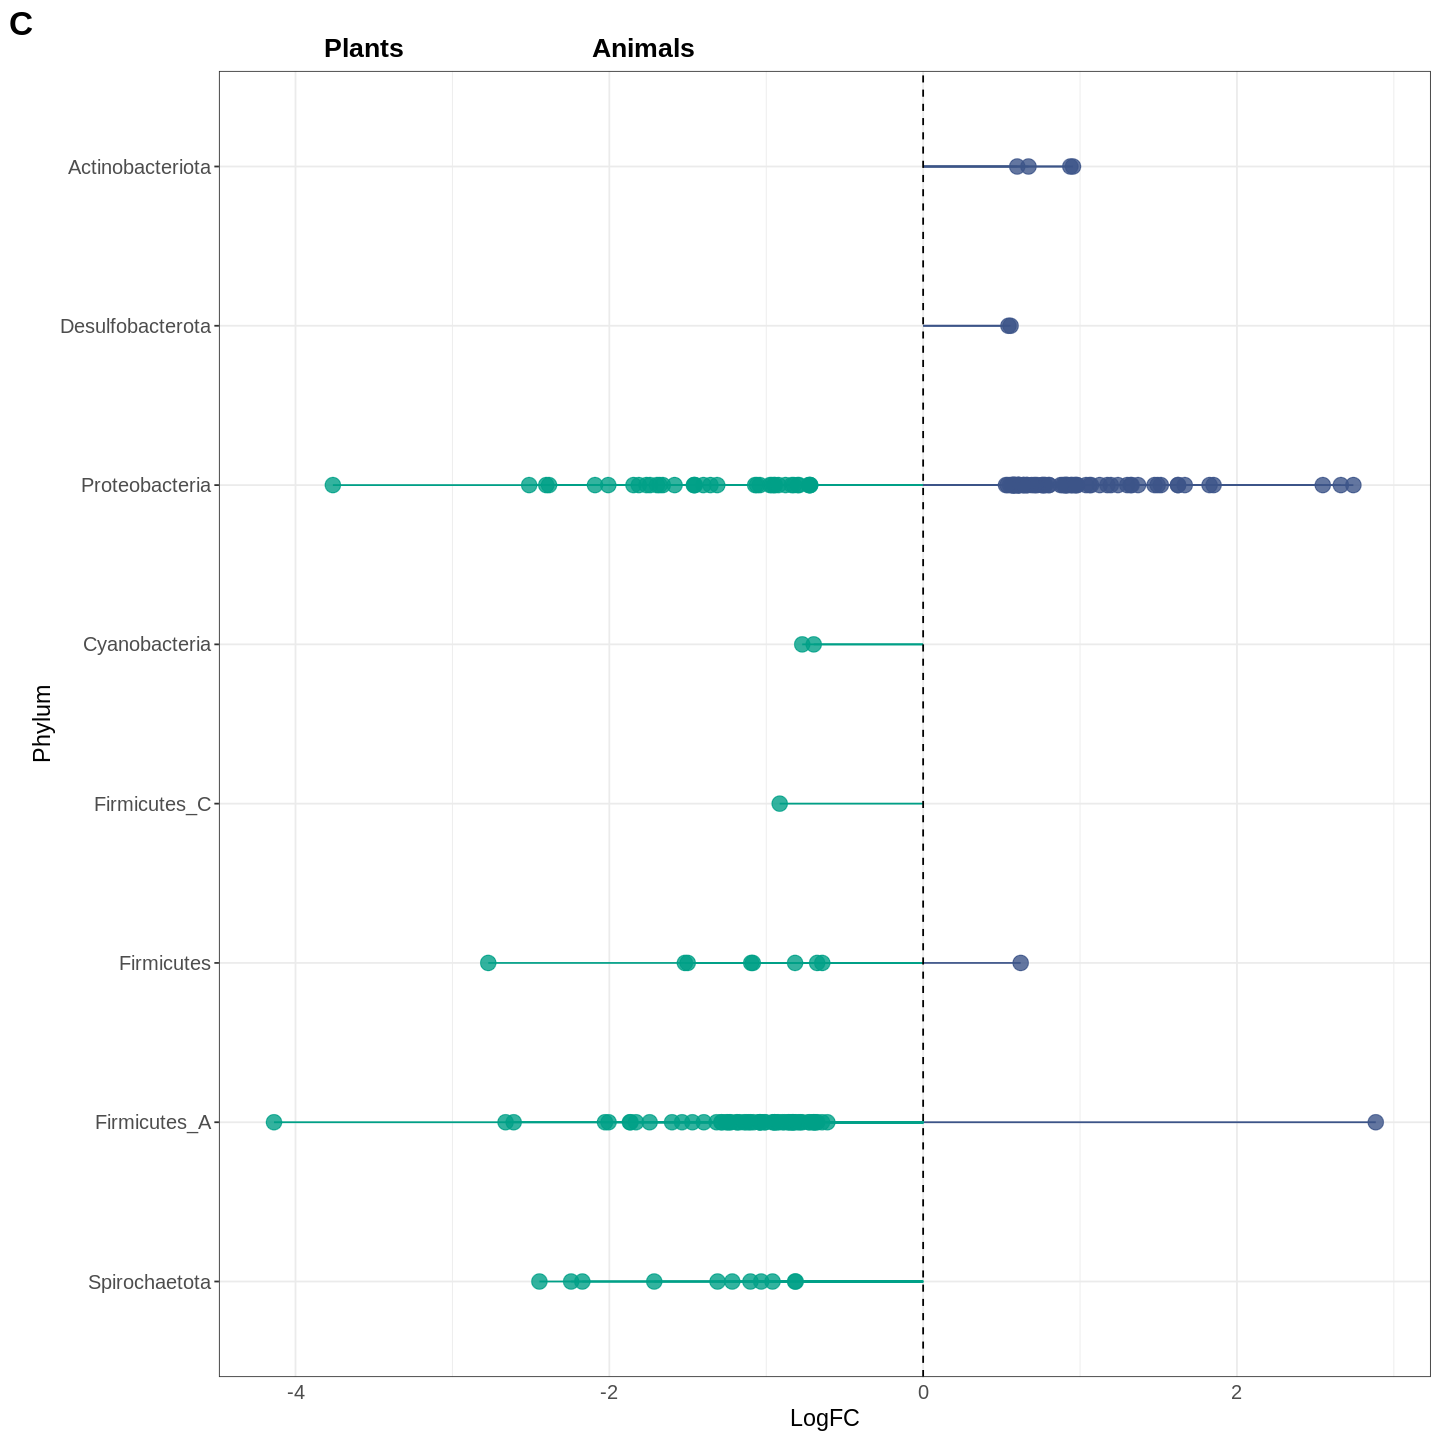

In [132]:
enriched.biome2

In [134]:
grobs.enr = list(c(tax.biome1,summ.biome2,enriched.biome1,enriched.biome2))

In [103]:
typeof(tax.biome1)

[1] "list"

In [80]:
library(gridExtra)

In [135]:
lay = rbind(c(1,1,3,3),
            c(2,2,4,4))

In [147]:
pdf("../../FlagellinDiversity/Figures/Figure8_opt2.pdf",pointsize=13,width=12,height=12)
grid.arrange(tax.biome1,summ.biome2,enriched.biome1,enriched.biome2, 
             layout_matrix = lay)    
dev.off()

Warning message:
“Duplicated aesthetics after name standardisation: yend”
Warning message:
“Duplicated aesthetics after name standardisation: yend”


png 
  2

### Animals

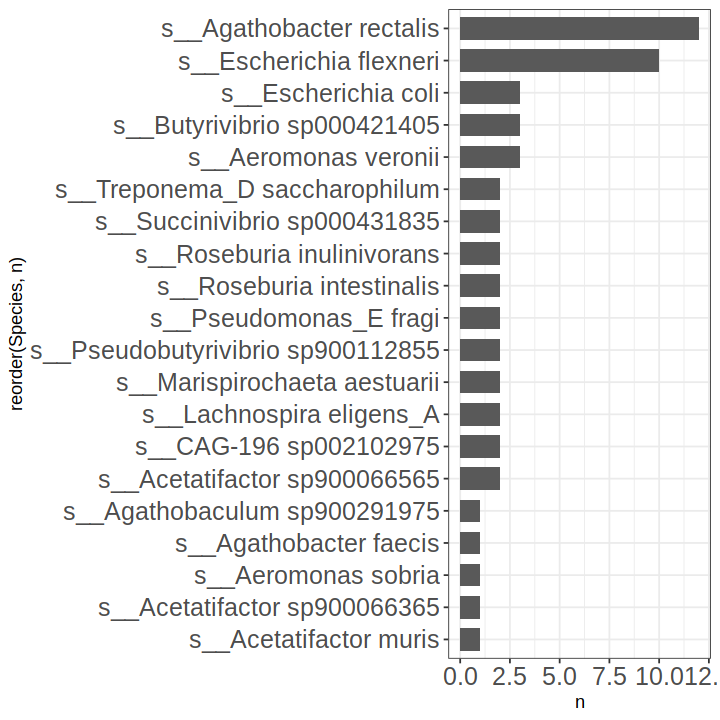

In [16]:
#Summarize number of flagellins per species
options(repr.plot.width = 6,repr.plot.height=6)
ggplot(count(tmpAn,Species,sort=TRUE)[1:20,],aes(y=reorder(Species,n),x=n))+
geom_bar(stat="identity",width=0.7)+
theme_bw()+
theme(axis.text.x = element_text(size=15),
     axis.text.y = element_text(size=15))

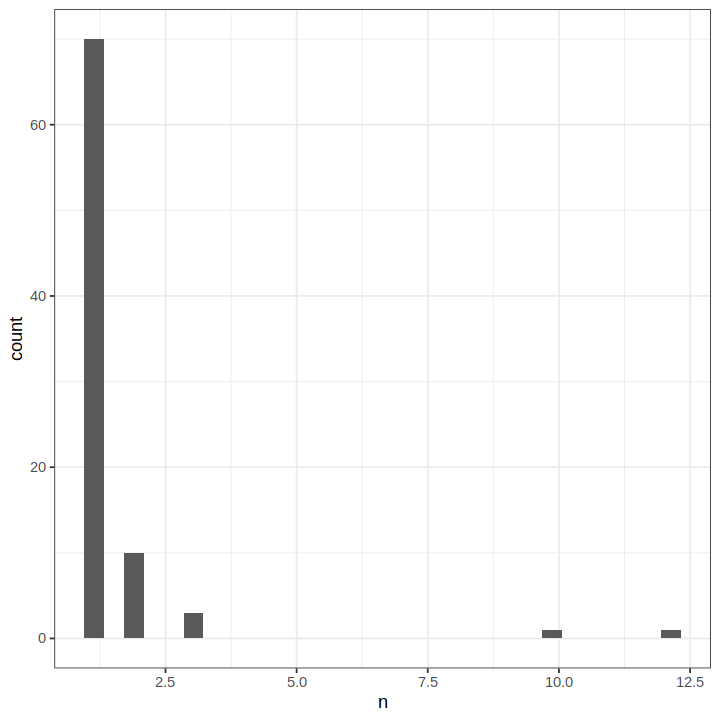

In [82]:
#Check distribution of flagellins/species
options(repr.plot.width = 6,repr.plot.height=6)
ggplot(count(tmpAn,Species,sort=TRUE),aes(x=n))+
theme_bw()+
geom_histogram(bins = 30)

#### Filter sequences

##### B. Extract species with > 1 flagellin

In [18]:
extractAn = semi_join(tmpAn, #taxonomy of enriched flagellins in animals
                      count(tmpAn,Species,sort=TRUE) %>% filter(n>1), #Extract species with more than one flagellin
                     by="Species") #join by species name

Accession,Domain,Phylum,Class,Order,Family,Genus,Species,logFC,logCPM,PValue,FDR,EnrichedIn
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
RHP37040.1,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__Acetatifactor,s__Acetatifactor sp900066565,-4.137041,12.78049,3.316435e-22,7.255623e-20,Animals
EIC00583.1,d__Bacteria,p__Spirochaetota,c__Spirochaetia,o__Treponematales,f__Treponemataceae,g__Treponema_D,s__Treponema_D saccharophilum,-2.171939,11.27565,1.081223e-13,7.884922e-12,Animals
WP_072280274.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Enterobacteriaceae,g__Escherichia,s__Escherichia flexneri,-2.402003,11.39881,1.132341e-13,7.962783e-12,Animals
CDC79573.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Enterobacterales,f__Enterobacteriaceae,g__Escherichia,s__Escherichia coli,-2.091190,11.20323,3.948165e-12,2.429355e-10,Animals
SEK95452.1,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__Pseudobutyrivibrio,s__Pseudobutyrivibrio sp900112855,-1.864833,11.07126,7.111111e-12,4.118170e-10,Animals
RHU62160.1,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__Acetatifactor,s__Acetatifactor sp900066565,-2.004874,11.16386,1.056193e-11,5.776789e-10,Animals


In [19]:
keep.prot.animals = flagellins.markers.sb[c(which(names(flagellins.markers.sb) %in% extractAn$Accession))]
write.fasta(sequences=keep.prot.animals,names=names(keep.prot.animals),nbchar=80,file.out="subsampled_opt1/multipleFlasPerSpecies_animals.faa")

In [24]:
write_tsv(extractAn,file="subsampled_opt1/multipleFlasPerSpecies_animals.tsv")

In [20]:
#Export flagellins from Agathobacter - 12 flagellins
keepAnimalsAgathobacter = flagellins.markers.sb[c(which(names(flagellins.markers.sb) %in% (filter(extractAn,Species=="s__Agathobacter rectalis")$Accession)))]
write.fasta(sequences=keepAnimalsAgathobacter,names = names(keepAnimalsAgathobacter),nbchar=80,file.out="subsampled_opt1/Agathobacter_animals.faa")

### Plants

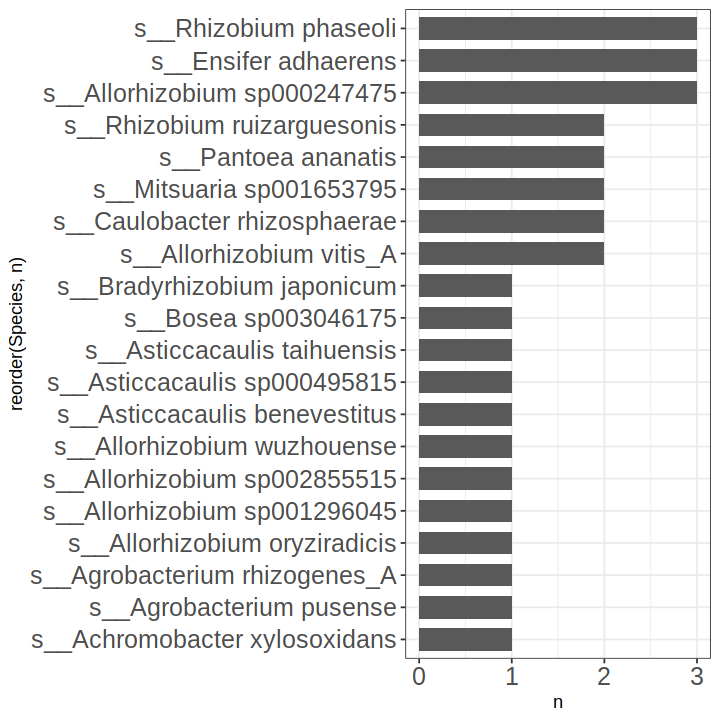

In [25]:
#Summarize number of flagellins per species
options(repr.plot.width = 6,repr.plot.height=6)
ggplot(count(tmpPl,Species,sort=TRUE)[1:20,],aes(y=reorder(Species,n),x=n))+
geom_bar(stat="identity",width=0.7)+
theme_bw()+
theme(axis.text.x = element_text(size=15),
     axis.text.y = element_text(size=15))

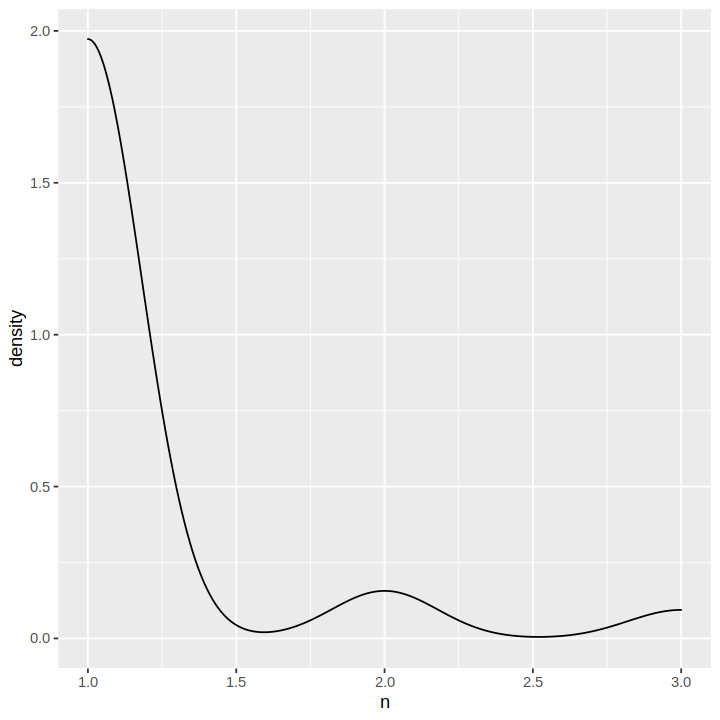

In [26]:
#Check distribution of number of flagellins per species
ggplot(count(tmpPl,Species,sort=TRUE),aes(x=n))+
geom_density()

#### Filter sequences

##### B. Extract species with > 1 flagellin

In [27]:
#### Extract flagellins from species with >1 flagellin
extractPl = semi_join(tmpPl, #taxonomy of enriched flagellins in plants
                      count(tmpPl,Species,sort=TRUE) %>% filter(n>1), #Extract species with more than one flagellin
                     by="Species") #join by species name
head(extractPl)

Accession,Domain,Phylum,Class,Order,Family,Genus,Species,logFC,logCPM,PValue,FDR,EnrichedIn
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
EHS52757.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Rhizobiaceae,g__Allorhizobium,s__Allorhizobium sp000247475,2.741936,11.02470,1.162711e-45,1.144689e-42,Plants
EHS53753.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Rhizobiaceae,g__Allorhizobium,s__Allorhizobium sp000247475,2.662170,11.01887,9.249745e-44,6.070916e-41,Plants
EHS53752.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Rhizobiaceae,g__Allorhizobium,s__Allorhizobium sp000247475,2.546891,10.93027,1.695101e-41,8.344137e-39,Plants
ACE93333.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Rhizobiaceae,g__Rhizobium,s__Rhizobium phaseoli,1.494688,10.59173,1.181276e-20,2.325932e-18,Plants
WP_109855741.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Rhizobiaceae,g__Ensifer,s__Ensifer adhaerens,1.624468,10.60927,1.297648e-19,2.322789e-17,Plants
WP_028734014.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Rhizobiaceae,g__Rhizobium,s__Rhizobium ruizarguesonis,1.474867,10.57286,2.409948e-19,3.954323e-17,Plants


In [28]:
keep.prot.plants = flagellins.markers.sb[c(which(names(flagellins.markers.sb) %in% extractPl$Accession))]
write.fasta(sequences=keep.prot.plants,
            names=names(keep.prot.plants),
            nbchar=80,
            file.out="subsampled_opt1/multipleFlasPerGenus_plants.faa")

In [31]:
write_tsv(extractPl,file="subsampled_opt1/multipleFlasPerSpecies_plants.tsv")

### Free-living

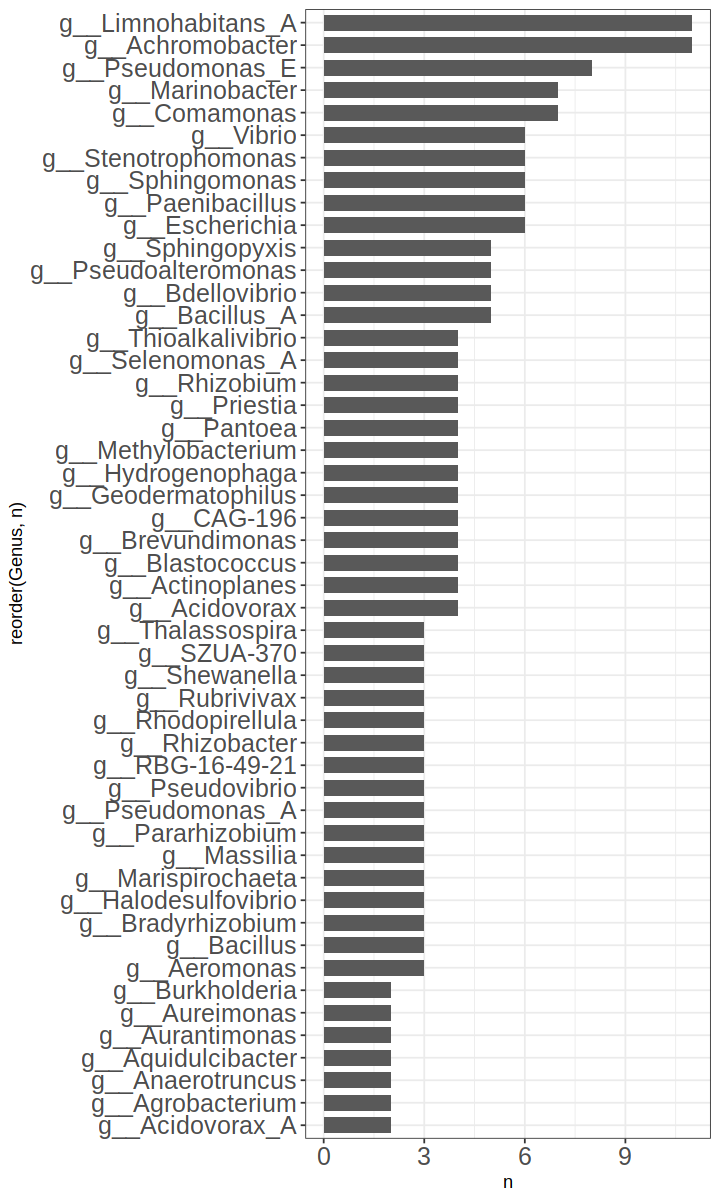

In [32]:
#Summarize number of flagellins per species
options(repr.plot.width = 6,repr.plot.height=10)
ggplot(count(DA.env,Genus,sort=TRUE)[1:50,],aes(y=reorder(Genus,n),x=n))+
geom_bar(stat="identity",width=0.7)+
theme_bw()+
theme(axis.text.x = element_text(size=15),
     axis.text.y = element_text(size=15))

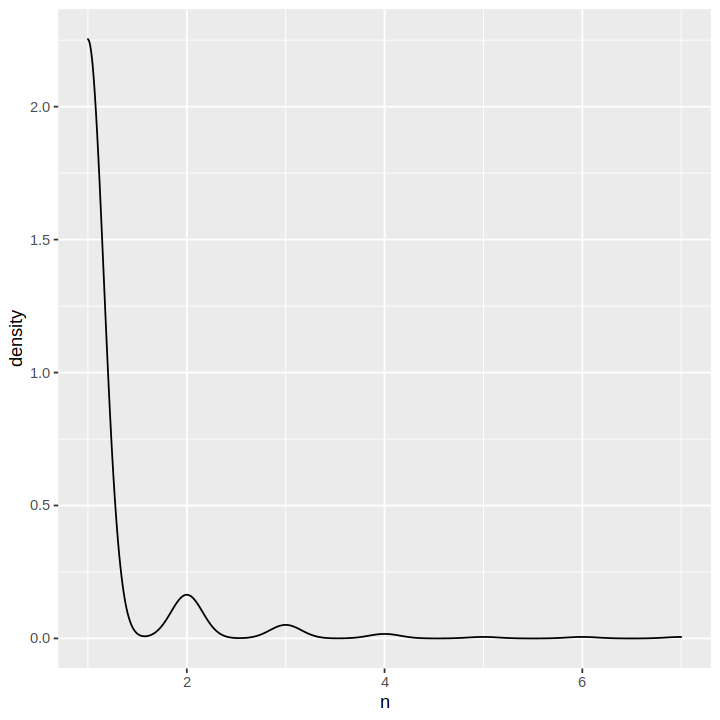

In [33]:
#Check distribution of # flagellins per species
options(repr.plot.width = 6,repr.plot.height=6)
ggplot(count(DA.env,Species,sort=TRUE),aes(x=n))+
geom_density()

#### Filter sequences

##### B. Extract species with > 1 flagellin

In [34]:
#### Extract flagellins from species with >1 flagellin
extractEnv = semi_join(DA.env, #taxonomy of enriched flagellins in free-living
                      count(DA.env,Species,sort=TRUE) %>% filter(n>1), #Extract species with more than one flagellin
                     by="Species") #join by species name
head(extractEnv)

Accession,Domain,Phylum,Class,Order,Family,Genus,Species,logFC,logCPM,PValue,FDR,EnrichedIn
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ORC34218.1,d__Bacteria,p__Spirochaetota,c__Spirochaetia,o__JC444,f__Marispirochaetaceae,g__Marispirochaeta,s__Marispirochaeta aestuarii,-2.967947,11.40375,3.992201e-47,1.311438e-44,Environmental
SOB91381.1,d__Bacteria,p__Firmicutes,c__Bacilli,o__Bacillales_A,f__Planococcaceae,g__Ureibacillus,s__Ureibacillus xyleni,-2.600297,10.86048,7.213992e-45,2.031254e-42,Environmental
OAS88434.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Burkholderiales,f__Burkholderiaceae,g__Achromobacter,s__Achromobacter xylosoxidans,-2.135009,11.36545,9.798241e-45,2.414042e-42,Environmental
KOQ58417.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Burkholderiales,f__Burkholderiaceae,g__Achromobacter,s__Achromobacter xylosoxidans,-1.919139,11.23390,1.648843e-41,2.499899e-39,Environmental
WP_116520833.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Burkholderiales,f__Burkholderiaceae,g__Achromobacter,s__Achromobacter insuavis,-1.944934,11.19566,2.478477e-40,3.489342e-38,Environmental
OHD63782.1,d__Bacteria,p__Spirochaetota,c__UBA4802,o__UBA4802,f__UBA5550,g__RBG-16-49-21,s__RBG-16-49-21 sp001829455,-1.691385,10.54732,4.494092e-32,4.218026e-30,Environmental


In [35]:
keep.prot.env = flagellins.markers.sb[c(which(names(flagellins.markers.sb) %in% extractEnv$Accession))]

In [36]:
length(keep.prot.env)

[1] 115

In [37]:
write.fasta(sequences=keep.prot.env,
            names=names(keep.prot.env),
            nbchar=80,
            file.out="subsampled_opt1/multipleFlasPerSpecies_env.faa")

In [38]:
write_tsv(extractEnv,file="subsampled_opt1/multipleFlasPerSpecies_env.tsv")

## Dereplicate by genus

In [293]:
#Dereplicate all lists of enriched flagellins, to the genus level
derepList_raw = lapply(listEnrichedBiomes,FilterSingleRepresentative,Genus)

[1] 219
[1] 25
[1] 38


In [292]:
#Dereplicate all lists of enriched flagellins, to the genus level
derepList_raw = lapply(listEnrichedBiomes,FilterSingleRepresentative,Species)

[1] 398
[1] 63
[1] 70


In [294]:
#Dereplicate all lists of enriched flagellins, to the genus level - downsample to the lowest species count/habitat
derepList.2 = lapply(listEnrichedBiomes,FilterSingleRepresentative,Species,subsample=TRUE,25)

[1] 25
[1] 25
[1] 25


In [170]:
#Dereplicate all lists of enriched flagellins, to the genus level - downsample to the lowest species count/habitat
derepList = lapply(listEnrichedBiomes,FilterSingleRepresentative,Genus,subsample=TRUE,25)

[1] 25
[1] 25
[1] 25


In [296]:
derepTest = bind_rows(derepList.2)

In [171]:
#Creates a table with all lists
derepAll = bind_rows(derepList)

#### Export fasta files

#### A. Without downsampling

In [184]:
categoriesToExport = c("animals","plants","free_living")

In [192]:
for (category in categoriesToExport) {
  output_file <- paste("subsampled_opt1/derep_genus_", category, ".faa", sep = "")
  export_sequences_to_fasta(sequence_fasta = flagellins.markers.sb,
                            seqList = derepList_raw,
                            category = category,
                            output_file = output_file)
}

#### B. With downsampling

In [193]:
for (category in categoriesToExport) {
  output_file <- paste("subsampled_opt1/derep_genus_downs_", category, ".faa", sep = "")
  export_sequences_to_fasta(sequence_fasta = flagellins.markers.sb,
                            seqList = derepList,
                            category = category,
                            output_file = output_file)
}

## Compare species diversity after dereplicating

### A. Only dereplication by genus

In [214]:
plotSummary =function(derepList){
    tmp.tax = lapply(derepList,getTaxSummary)
    tax.summ = bind_rows(tmp.tax)
    melt.tax = melt(tax.summ)
   
   plotSummary = ggplot(data = melt.tax, aes(x = EnrichedIn, y = value, fill = EnrichedIn)) +
        geom_bar(stat = "identity", width = 0.7) +
        geom_text(aes(label=value,vjust=-0.5))+
        labs(title = "Taxonomic Summary",
        x = "", y = "No. Features") +
        theme_bw() +
        scale_fill_viridis_d()+
        theme(legend.position = "top",
         axis.text.x = element_blank(),
         axis.text.y = element_text(size=15),
         axis.title.y= element_text(size=15),
         legend.text = element_text(size=14),
         legend.title = element_text(size=14,"bold"),
         strip.text = (element_text(size=15)))+
        facet_wrap(~variable,scales="free_y",nrow=2)

    
return(list(plot = plotSummary,tax.summary = tax.summ))
}

Using EnrichedIn as id variables



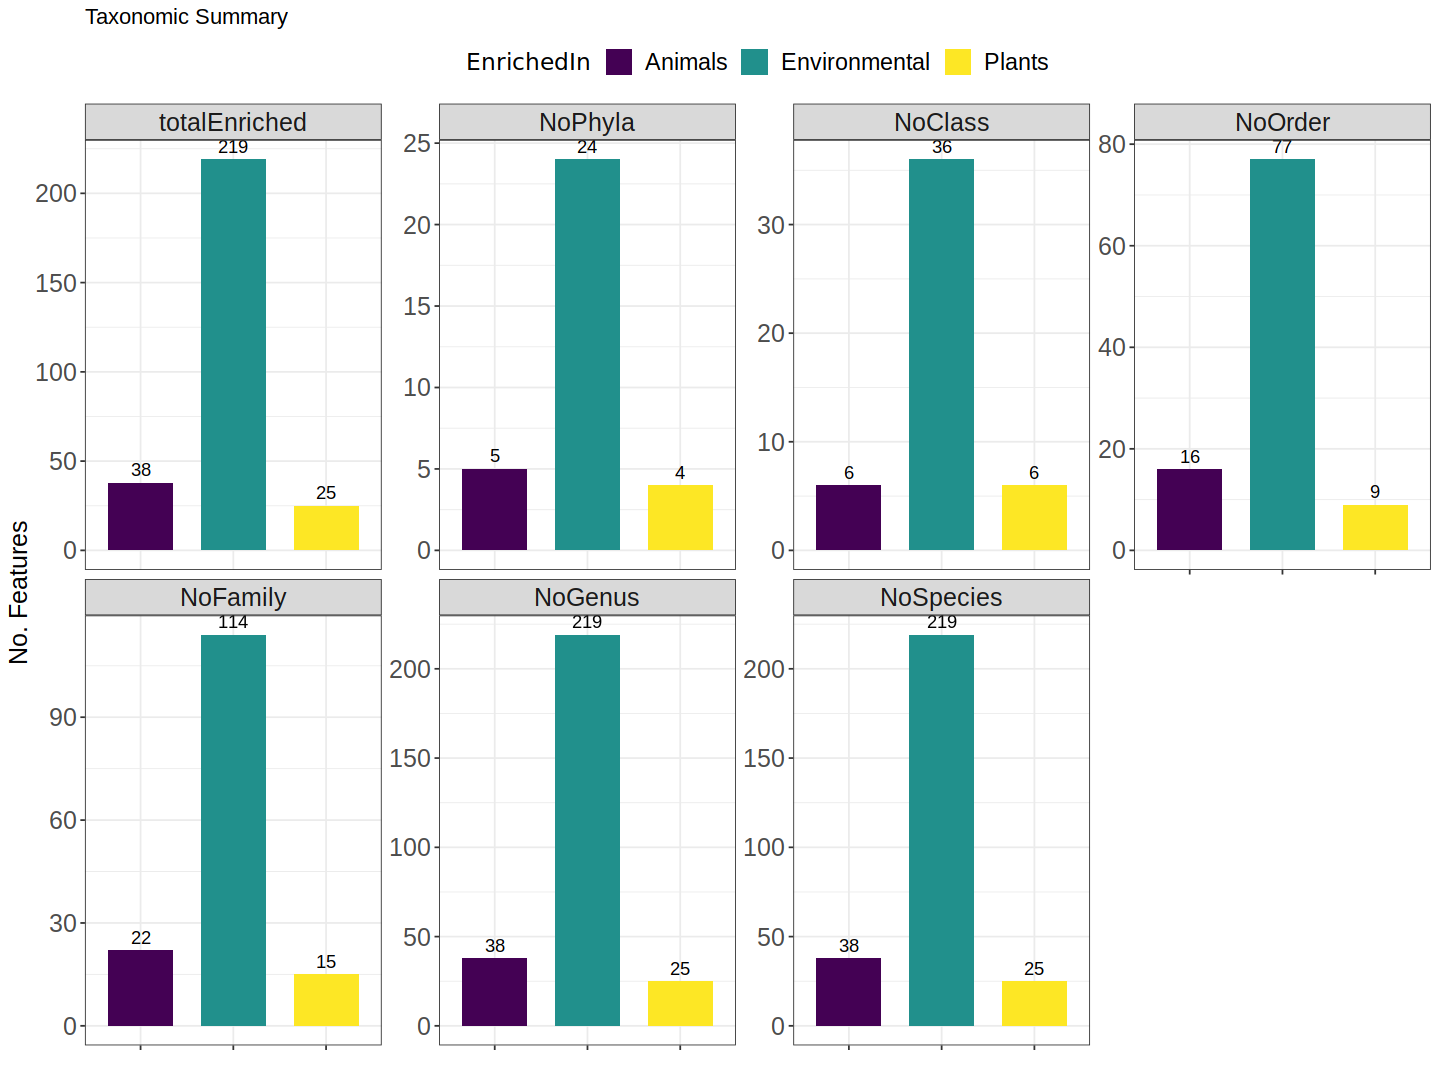

In [220]:
taxSumm.derep = plotSummary(derepList_raw)
taxSumm.derep$plot

### B. Dereplication + subsampling

Using EnrichedIn as id variables



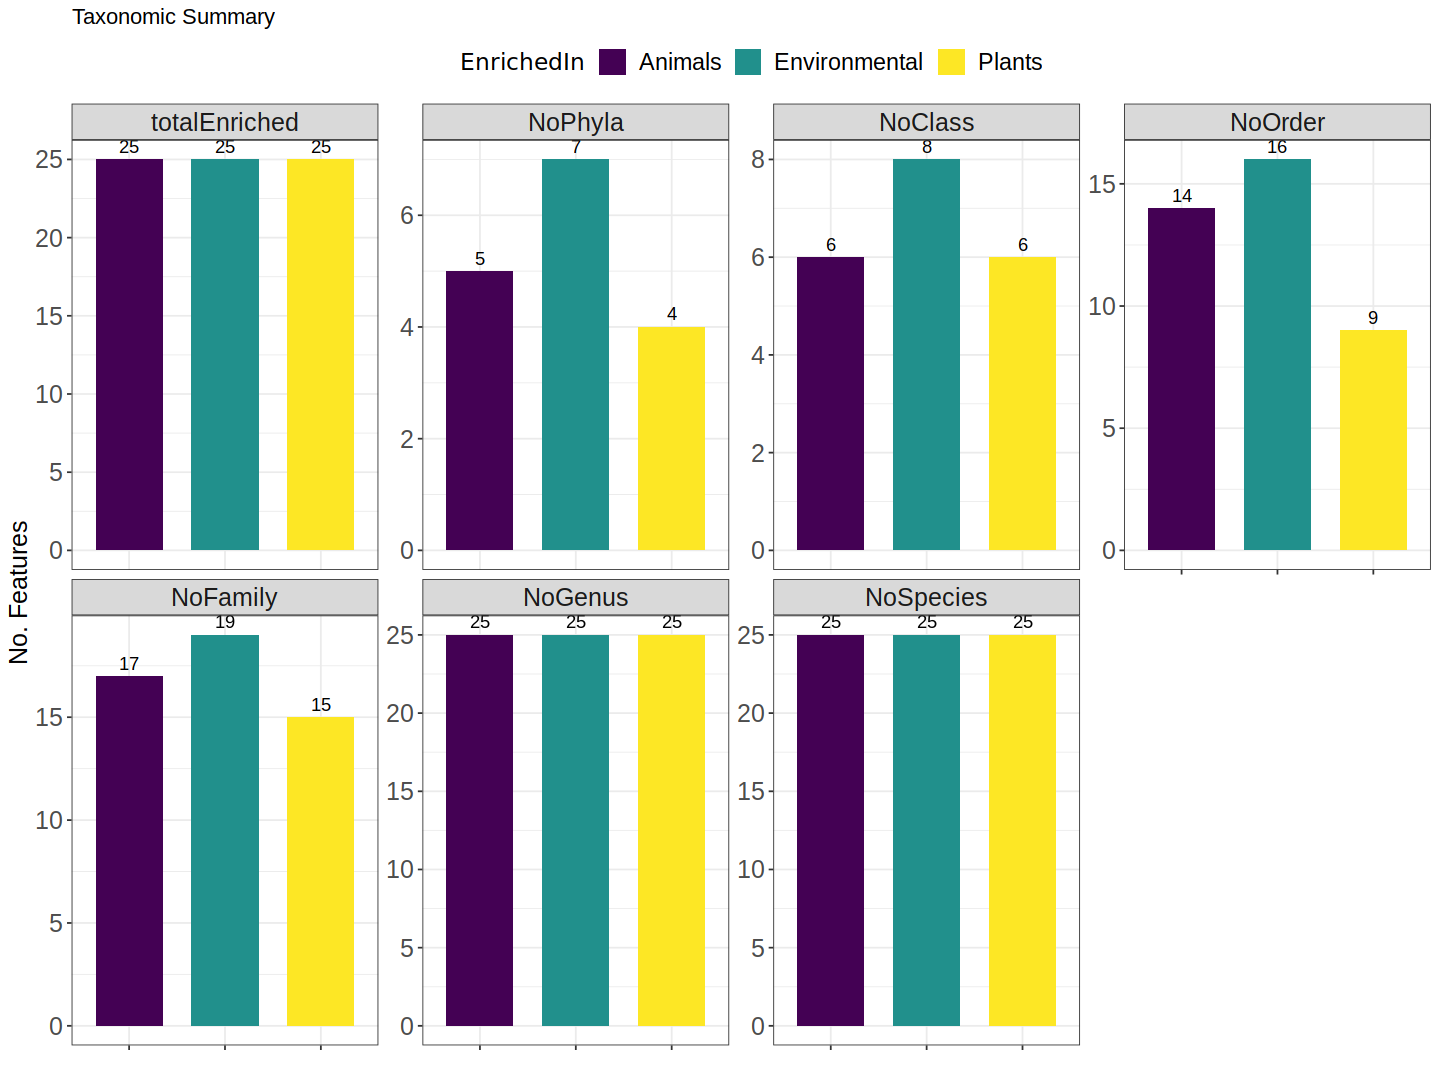

In [219]:
taxSumm.derep.subs = plotSummary(derepList)
taxSumm.derep.subs$plot

In [228]:
write_tsv(derepAll,"subsampled_opt1/cds//gold_standard/derep_downs_taxonomyAllBiomes.tsv")

In [254]:
head(derepAll)

Accession,Domain,Phylum,Class,Order,Family,Genus,Species,logFC,logCPM,PValue,FDR,EnrichedIn
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
WP_047153542.1,d__Bacteria,p__Firmicutes,c__Bacilli,o__Aneurinibacillales,f__Aneurinibacillaceae,g__Aneurinibacillus_A,s__Aneurinibacillus_A tyrosinisolvens,-1.533330,10.55997,6.141193e-31,5.501951e-29,Environmental
WP_096663659.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Burkholderiales,f__Burkholderiaceae,g__Polaromonas,s__Polaromonas sp002379085,-0.666665,10.31514,7.365130e-07,4.838890e-06,Environmental
PYN97132.1,d__Bacteria,p__Methylomirabilota,c__Methylomirabilia,o__Rokubacteriales,f__GWA2-73-35,g__20CM-2-70-11,s__20CM-2-70-11 sp003220315,-1.943326,11.15991,1.084073e-42,2.374121e-40,Environmental
ODT06014.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhizobiales,f__Rhizobiaceae,g__Aminobacter,s__Aminobacter sp001724355,-1.210606,10.46953,2.170064e-17,4.916317e-16,Environmental
ASP19302.1,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,g__Antarctobacter,s__Antarctobacter heliothermus_B,-0.517563,10.27079,7.996125e-05,3.752467e-04,Environmental
STY26135.1,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Legionellales,f__Legionellaceae,g__Legionella_C,s__Legionella_C taurinensis,-1.189839,10.46299,1.454854e-16,2.956204e-15,Environmental


#TO DO: Check nucleotide diversity

In [39]:
protAn = read.fasta("subsampled_opt1/cds/codon_alignments/all.cds.prot.animals.faa")

In [40]:
alignment_an  = ape::as.alignment(protAn)

In [236]:
M0=-18539.803091
M1=-17447.711581
M2=-17344.862071
M7=-17366.238038
M8=-17250.977257

In [247]:
diff_M0vsM1a = 2*( M1 - M0 )
diff_M1vsM2 = 2*(M2-M1)

In [243]:
M0

[1] -18539.8

In [248]:
diff_M0vsM1a

[1] 2184.183

In [251]:
pchisq(diff_M0vsM1a, df = 1, lower.tail=F )

[1] 0

In [252]:
pchisq(diff_M1vsM2, df = 2, lower.tail=F )

[1] 2.152907e-45

In [ ]:
Chisq.crit.M1vsM2a <- qchisq( p = 0.95, df = 2 )
# alpha critical value at 5% level = 5.991465
Chisq.crit.M1vsM2a_2 <- qchisq( p = 0.99, df = 2 )
# alpha critical value at 1% level = 9.21034

# In addition, we can run an additional comparison between 
# M7 (beta) and M8 (beta&omega).
## M7 vs M8 ##
diff_M7vsM8 <- 2*( lnL_vals$Model_8[1] - lnL_vals$Model_7[1] )
# 12.5435
pchisq( diff_M7vsM8, df = 2, lower.tail=F )
# p-val = 0.001888922 < 0.05
Chisq.crit.M7vsM8 <- qchisq( p = 0.95, df = 2 )
# alpha critical value at 5% level = 5.991465
Chisq.crit.M7vsM8_2 <- qchisq( p = 0.99, df = 2 )
# alpha critical value at 1% level = 9.21034

# 3. Plot results 
par( mfrow = c(1, 3) )